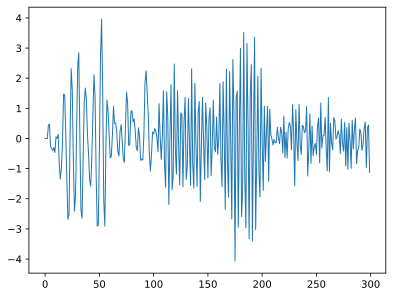

In [12]:
from scipy import io
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import gurobipy as gb
cd_data = io.loadmat('change_detection.mat')

cd_y = cd_data["y"]

plt.plot(cd_y, linewidth = 1)
plt.show()

In [3]:
def regression(y, sample_size, norm = 1):
    model = pyo.AbstractModel()
    model.data_index_set = pyo.RangeSet(sample_size)
    model.y = pyo.Param(model.data_index_set, initialize = lambda m,i: y[i - 1])

    model.var_index_set = model.data_index_set - {sample_size, sample_size - 1, sample_size - 2}
    model.a = pyo.Var()
    model.b = pyo.Var()
    model.c = pyo.Var()

    def rec_expr(m, i):
        return  model.y[i + 3] \
                - model.a * model.y[i + 2] \
                - model.b * model.y[i + 1] \
                - model.c * model.y[i]
    fun_obj = None
    if norm == 1:
        model.t1  = pyo.Var(model.var_index_set, domain = pyo.NonNegativeReals)
        model.t2  = pyo.Var(model.var_index_set, domain = pyo.NonNegativeReals)
        model.to_abs = pyo.Var(model.var_index_set)
        model.const_init_abs = pyo.Constraint(model.var_index_set, rule = lambda m,i: m.to_abs[i] == rec_expr(m,i))
        model.const_abs = pyo.Constraint(model.var_index_set, rule = lambda m,i: m.to_abs[i] == m.t1[i] - m.t2[i])
        fun_obj = lambda m: sum(m.t1[i] + m.t2[i] for i in m.var_index_set)

    else:
        fun_obj = lambda m: sum(rec_expr(m, i)**2 for i in m.var_index_set)

    model.obj = pyo.Objective(rule = fun_obj)

    model.construct()
    
    solver = pyo.SolverFactory("gurobi")
    report = solver.solve(model)
    return model, report

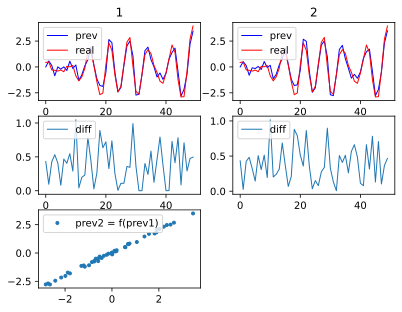

In [19]:
sample_size = 50
display_size = 50

model1, _ = regression(cd_y, sample_size, 1)
model2, _ = regression(cd_y, sample_size, 2)
def my_sub_plot(cd_y, model, column):
    lw = 1
    y = [model.a.value * cd_y[i + 2] + model.b.value * cd_y[i + 1] + model.c.value * cd_y[i] for i in range(display_size)]
    plt.subplot(3, 2, column)
    plt.title(str(column))
    plt.plot(y, color = 'blue', linewidth = lw, label = 'prev')
    plt.plot(cd_data["y"][3:display_size + 3], color = 'red', linewidth = lw, label = 'real')
    plt.legend()
    plt.subplot(3, 2, column + 2)
    plt.plot([abs(y[i] - cd_data['y'][i + 3]) for i in range(display_size)], linewidth = lw, label = 'diff')
    plt.legend()
    return y

y1 = my_sub_plot(cd_y, model1, 1)
y2 = my_sub_plot(cd_y, model2, 2)
plt.subplot(3,2,5)
plt.plot(y1, y2, '.', label = 'prev2 = f(prev1)')
plt.legend()
plt.show()



In [72]:
def change_detection(cd_y, sample_size, mu):
    model = pyo.AbstractModel()
    model.data_index_set = pyo.RangeSet(0, sample_size - 1)
    model.y = pyo.Param(model.data_index_set, initialize = lambda m,i: cd_y[i])

    model.var_index_set = model.data_index_set - {sample_size - 1, sample_size - 2, sample_size - 3}
    model.var_dim_set = pyo.RangeSet(3)
    
    model.w = pyo.Var(model.var_dim_set, model.var_index_set)

    model.var_d_set = model.var_index_set - {sample_size - 4}
    model.d_abs = pyo.Var(model.var_dim_set, model.var_d_set, {1 , 2}, domain = pyo.NonNegativeReals)
    
    model.contr_d = pyo.Constraint(model.var_dim_set, model.var_d_set,
                                   rule = lambda m, i, j: m.d_abs[i, j, 2] - m.d_abs[i, j, 1]  == m.w[i, j + 1] - m.w[i, j])

    def rec_expr(m, i):
        return  model.y[i + 3] \
                - model.w[1, i] * model.y[i + 2] \
                - model.w[2, i] * model.y[i + 1] \
                - model.w[3, i] * model.y[i]

    def obj_expr(m) :
        return sum(rec_expr(m, i)**2 for i in m.var_index_set) + mu * pyo.summation(m.d_abs)

    model.obj = pyo.Objective(rule = obj_expr)

    model.construct()

    solver = pyo.SolverFactory("gurobi")
    report = solver.solve(model)
    return model, report

sample_size = 300
mu = 100
model, report = change_detection(cd_y, sample_size, mu)
model.pprint()
print(report)

8 Set Declarations
    contr_d_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                : Size : Members
        None :     2 : var_dim_set*var_d_set :  888 : {(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60), (1, 61), (1, 62), (1, 63), (1, 64), (1, 65), (1, 66), (1, 67), (1, 68), (1, 69), (1, 70), (1, 71), (1, 72), (1, 73), (1, 74), (1, 75), (1, 76), (1, 77), (1, 78), (1, 79), (1, 80), (1, 81), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 87), (1, 88), (1, 89), (1, 90), (1

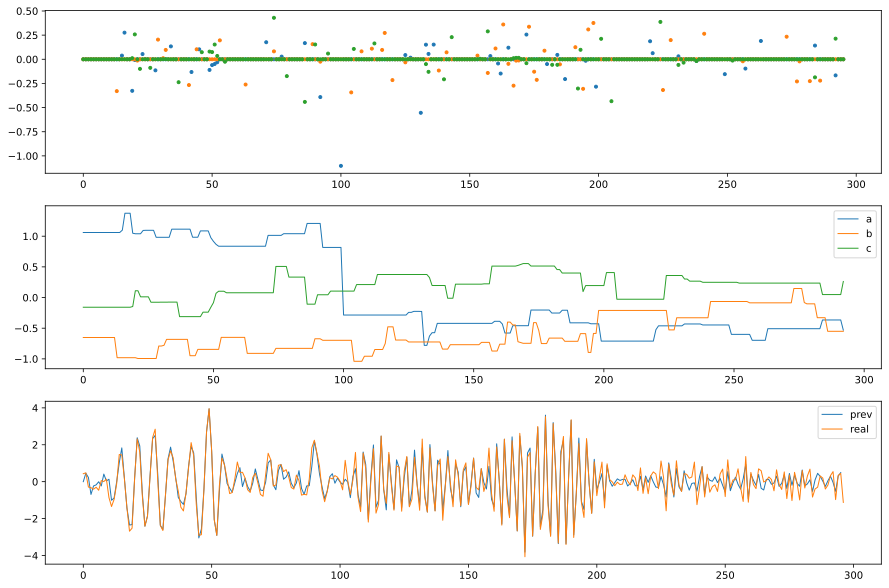

In [86]:
mu = 10
model, report = change_detection(cd_y, sample_size, mu)

label = ['a', 'b', 'c']
display_size = sample_size - 4
lw = 1
plt.figure(figsize=(15,10))
plt.subplot(311)
for i in {1, 2, 3}:
    plt.plot([model.d_abs[i, j, 2].value - model.d_abs[i, j, 1].value for j in range(display_size)], '.', linewidth = lw)
plt.subplot(312)
for i in {1,2,3}:
    plt.plot([model.w[i, j + 1].value for j in range(display_size - 3)], linewidth = lw, label = label[i -1])
plt.legend()

y = [model.w[1, i].value * cd_y[i + 2] + model.w[2, i].value * cd_y[i + 1] + model.w[3, i].value * cd_y[i] for i in range(display_size)]
plt.subplot(313)
plt.plot(y, linewidth = lw, label = 'prev')
plt.plot(cd_y[3:], linewidth = lw, label = 'real')
plt.legend()
plt.show()